In [1]:
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F
import numpy as np
import torch

with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)
with open('types.pkl', 'rb') as f:
    types = pickle.load(f)
with open('views.pkl', 'rb') as f:
    views = pickle.load(f)

In [2]:
features = features.reshape(features.shape[0], -1)

In [3]:
# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

In [4]:
import torch
import torch.nn.functional as F
# 使用 DBSCAN 聚类
eps = 12 # 邻域半径
min_samples = 8  # 核心点的最小邻域点数
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
pseudo_labels = dbscan.fit_predict(features)

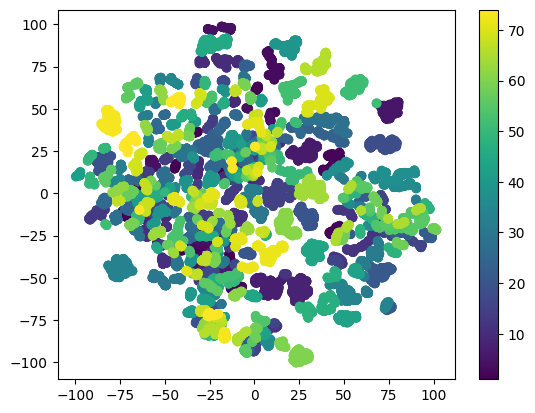

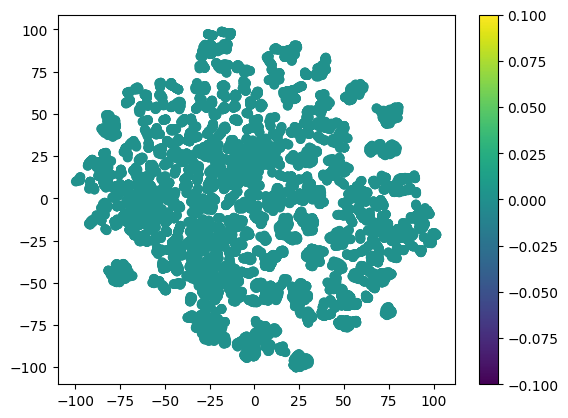

In [5]:
# from sklearn.metrics import silhouette_score
# score = silhouette_score(features, labels)
# print(score)
n = -1

plt.scatter(features_2d[:n, 0], features_2d[:n, 1], c=labels[:n], cmap='viridis')
plt.colorbar()
plt.show()

plt.scatter(features_2d[:n, 0], features_2d[:n, 1], c=pseudo_labels[:n], cmap='viridis')
plt.colorbar()
plt.show()

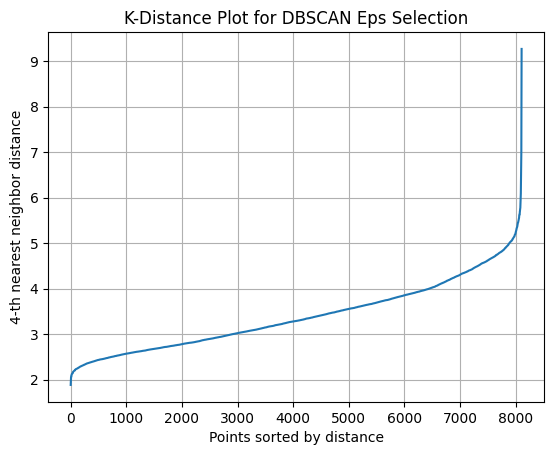

In [6]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# 假设 features 是二维数组 [n_samples, n_features]
k = 4  # 一般取 min_samples - 1
nbrs = NearestNeighbors(n_neighbors=k).fit(features)
distances, _ = nbrs.kneighbors(features)

# 对距离排序并绘图
k_distances = np.sort(distances[:, -1])  # 取第 k 个最近邻的距离
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("K-Distance Plot for DBSCAN Eps Selection")
plt.grid()
plt.show()


In [7]:
import os
import numpy as np
import faiss
import torch

def swig_ptr_from_FloatTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.float32
    return faiss.cast_integer_to_float_ptr(
        x.storage().data_ptr() + x.storage_offset() * 4)

def swig_ptr_from_LongTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.int64, 'dtype=%s' % x.dtype

    return faiss.cast_integer_to_idx_t_ptr(
        x.storage().data_ptr() + x.storage_offset() * 8)

def search_index_pytorch(index, x, k, D=None, I=None):
    """call the search function of an index with pytorch tensor I/O (CPU
    and GPU supported)"""
    assert x.is_contiguous()
    n, d = x.size()
    assert d == index.d

    if D is None:
        D = torch.empty((n, k), dtype=torch.float32, device=x.device)
    else:
        assert D.size() == (n, k)

    if I is None:
        I = torch.empty((n, k), dtype=torch.int64, device=x.device)
    else:
        assert I.size() == (n, k)
    torch.cuda.synchronize()
    xptr = swig_ptr_from_FloatTensor(x)
    Iptr = swig_ptr_from_LongTensor(I)
    Dptr = swig_ptr_from_FloatTensor(D)
    index.search_c(n, xptr,
                   k, Dptr, Iptr)
    torch.cuda.synchronize()
    return D, I

def search_raw_array_pytorch(res, xb, xq, k, D=None, I=None,
                             metric=faiss.METRIC_L2):
    assert xb.device == xq.device

    nq, d = xq.size()
    if xq.is_contiguous():
        xq_row_major = True
    elif xq.t().is_contiguous():
        xq = xq.t()    # I initially wrote xq:t(), Lua is still haunting me :-)
        xq_row_major = False
    else:
        raise TypeError('matrix should be row or column-major')

    xq_ptr = swig_ptr_from_FloatTensor(xq)

    nb, d2 = xb.size()
    assert d2 == d
    if xb.is_contiguous():
        xb_row_major = True
    elif xb.t().is_contiguous():
        xb = xb.t()
        xb_row_major = False
    else:
        raise TypeError('matrix should be row or column-major')
    xb_ptr = swig_ptr_from_FloatTensor(xb)

    if D is None:
        D = torch.empty(nq, k, device=xb.device, dtype=torch.float32)
    else:
        assert D.shape == (nq, k)
        assert D.device == xb.device

    if I is None:
        I = torch.empty(nq, k, device=xb.device, dtype=torch.int64)
    else:
        assert I.shape == (nq, k)
        assert I.device == xb.device

    D_ptr = swig_ptr_from_FloatTensor(D)
    I_ptr = swig_ptr_from_LongTensor(I)

    faiss.bruteForceKnn(res, metric,
                xb_ptr, xb_row_major, nb,
                xq_ptr, xq_row_major, nq,
                d, k, D_ptr, I_ptr)

    return D, I

def index_init_gpu(ngpus, feat_dim):
    flat_config = []
    for i in range(ngpus):
        cfg = faiss.GpuIndexFlatConfig()
        cfg.useFloat16 = False
        cfg.device = i
        flat_config.append(cfg)

    res = [faiss.StandardGpuResources() for i in range(ngpus)]
    indexes = [faiss.GpuIndexFlatL2(res[i], feat_dim, flat_config[i]) for i in range(ngpus)]
    index = faiss.IndexShards(feat_dim)
    for sub_index in indexes:
        index.add_shard(sub_index)
    index.reset()
    return index

def index_init_cpu(feat_dim):
    return faiss.IndexFlatL2(feat_dim)

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CVPR2017 paper:Zhong Z, Zheng L, Cao D, et al. Re-ranking Person Re-identification with k-reciprocal Encoding[J]. 2017.
url:http://openaccess.thecvf.com/content_cvpr_2017/papers/Zhong_Re-Ranking_Person_Re-Identification_CVPR_2017_paper.pdf
Matlab version: https://github.com/zhunzhong07/person-re-ranking
"""

import os, sys
import time
import numpy as np
from scipy.spatial.distance import cdist
import gc
import faiss

import torch
import torch.nn.functional as F

def k_reciprocal_neigh(initial_rank, i, k1):
    forward_k_neigh_index = initial_rank[i,:k1+1]
    backward_k_neigh_index = initial_rank[forward_k_neigh_index,:k1+1]
    fi = np.where(backward_k_neigh_index==i)[0]
    return forward_k_neigh_index[fi]


def compute_jaccard_distance(target_features, k1=20, k2=6, print_flag=True, search_option=0, use_float16=False):
    end = time.time()
    if print_flag:
        print('Computing jaccard distance...')

    ngpus = faiss.get_num_gpus()
    N = target_features.size(0)
    mat_type = np.float16 if use_float16 else np.float32

    if (search_option==0):
        # GPU + PyTorch CUDA Tensors (1)
        res = faiss.StandardGpuResources()
        res.setDefaultNullStreamAllDevices()
        _, initial_rank = search_raw_array_pytorch(res, target_features, target_features, k1)
        initial_rank = initial_rank.cpu().numpy()
    elif (search_option==1):
        # GPU + PyTorch CUDA Tensors (2)
        res = faiss.StandardGpuResources()
        index = faiss.GpuIndexFlatL2(res, target_features.size(-1))
        index.add(target_features.cpu().numpy())
        _, initial_rank = search_index_pytorch(index, target_features, k1)
        res.syncDefaultStreamCurrentDevice()
        initial_rank = initial_rank.cpu().numpy()
    elif (search_option==2):
        # GPU
        index = index_init_gpu(ngpus, target_features.size(-1))
        index.add(target_features.cpu().numpy())
        _, initial_rank = index.search(target_features.cpu().numpy(), k1)
    else:
        # CPU
        index = index_init_cpu(target_features.size(-1))
        index.add(target_features.cpu().numpy())
        _, initial_rank = index.search(target_features.cpu().numpy(), k1)


    nn_k1 = []
    nn_k1_half = []
    for i in range(N):
        nn_k1.append(k_reciprocal_neigh(initial_rank, i, k1))
        nn_k1_half.append(k_reciprocal_neigh(initial_rank, i, int(np.around(k1/2))))

    V = np.zeros((N, N), dtype=mat_type)
    for i in range(N):
        k_reciprocal_index = nn_k1[i]
        k_reciprocal_expansion_index = k_reciprocal_index
        for candidate in k_reciprocal_index:
            candidate_k_reciprocal_index = nn_k1_half[candidate]
            if (len(np.intersect1d(candidate_k_reciprocal_index,k_reciprocal_index)) > 2/3*len(candidate_k_reciprocal_index)):
                k_reciprocal_expansion_index = np.append(k_reciprocal_expansion_index,candidate_k_reciprocal_index)

        k_reciprocal_expansion_index = np.unique(k_reciprocal_expansion_index)  ## element-wise unique
        dist = 2-2*torch.mm(target_features[i].unsqueeze(0).contiguous(), target_features[k_reciprocal_expansion_index].t())
        if use_float16:
            V[i,k_reciprocal_expansion_index] = F.softmax(-dist, dim=1).view(-1).cpu().numpy().astype(mat_type)
        else:
            V[i,k_reciprocal_expansion_index] = F.softmax(-dist, dim=1).view(-1).cpu().numpy()

    del nn_k1, nn_k1_half

    if k2 != 1:
        V_qe = np.zeros_like(V, dtype=mat_type)
        for i in range(N):
            V_qe[i,:] = np.mean(V[initial_rank[i,:k2],:], axis=0)
        V = V_qe
        del V_qe

    del initial_rank

    invIndex = []
    for i in range(N):
        invIndex.append(np.where(V[:,i] != 0)[0])  #len(invIndex)=all_num

    jaccard_dist = np.zeros((N, N), dtype=mat_type)
    for i in range(N):
        temp_min = np.zeros((1, N), dtype=mat_type)
        # temp_max = np.zeros((1,N), dtype=mat_type)
        indNonZero = np.where(V[i, :] != 0)[0]
        indImages = []
        indImages = [invIndex[ind] for ind in indNonZero]
        for j in range(len(indNonZero)):
            temp_min[0, indImages[j]] = temp_min[0, indImages[j]]+np.minimum(V[i, indNonZero[j]], V[indImages[j], indNonZero[j]])
            # temp_max[0,indImages[j]] = temp_max[0,indImages[j]]+np.maximum(V[i,indNonZero[j]],V[indImages[j],indNonZero[j]])

        jaccard_dist[i] = 1-temp_min/(2-temp_min)
        # jaccard_dist[i] = 1-temp_min/(temp_max+1e-6)

    del invIndex, V

    pos_bool = (jaccard_dist < 0)
    jaccard_dist[pos_bool] = 0.0
    if print_flag:
        print("Jaccard distance computing time cost: {}".format(time.time()-end))

    return jaccard_dist

In [13]:
features = torch.Tensor(features).to('cuda')
dists = compute_jaccard_distance(features, search_option=3)

Computing jaccard distance...
Jaccard distance computing time cost: 10.880253076553345


In [14]:
# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(dists)

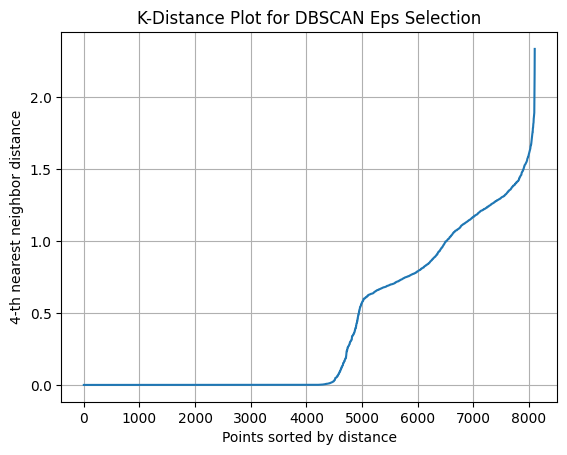

In [17]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# 假设 features 是二维数组 [n_samples, n_features]
k = 4  # 一般取 min_samples - 1
nbrs = NearestNeighbors(n_neighbors=k).fit(dists)
distances, _ = nbrs.kneighbors(dists)

# 对距离排序并绘图
k_distances = np.sort(distances[:, -1])  # 取第 k 个最近邻的距离
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("K-Distance Plot for DBSCAN Eps Selection")
plt.grid()
plt.show()


In [18]:
import torch
import torch.nn.functional as F
# 使用 DBSCAN 聚类
eps = 1 # 邻域半径
min_samples = 8  # 核心点的最小邻域点数
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
pseudo_labels = dbscan.fit_predict(dists)

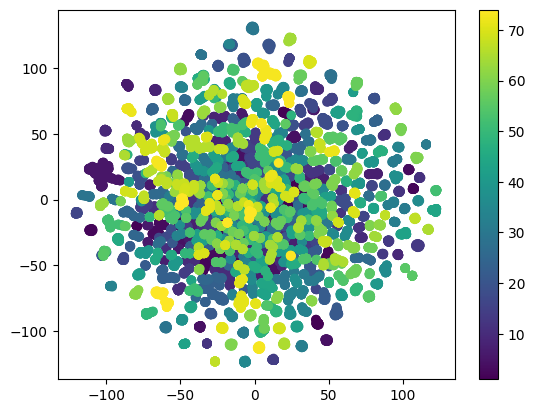

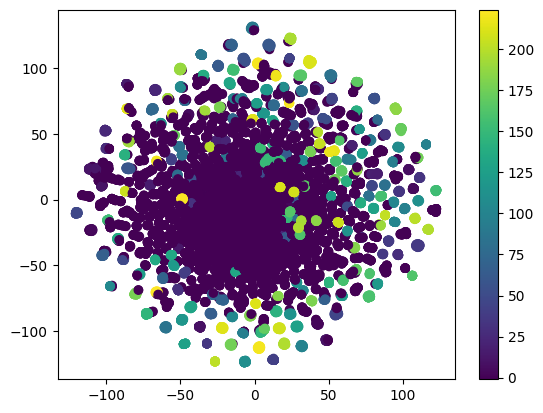

In [20]:
# from sklearn.metrics import silhouette_score
# score = silhouette_score(features, labels)
# print(score)
n = -1

plt.scatter(features_2d[:n, 0], features_2d[:n, 1], c=labels[:n], cmap='viridis')
plt.colorbar()
plt.show()

plt.scatter(features_2d[:n, 0], features_2d[:n, 1], c=pseudo_labels[:n], cmap='viridis')
plt.colorbar()
plt.show()